# Workbook for MIMIC Hypercapnia Presenting Chief Concern Analysis

Requirements: 

- MIMIC tabular dataset including columns
- natural language processing with ModernBERT

TODO: 

- still need to get comorbidity data
- need to extra ED only diagnosis

In [2]:
import sys, site, pprint, subprocess, importlib
print("Python:", sys.version)
print("Executable:", sys.executable)
print("Site-packages:")
pprint.pprint(site.getsitepackages())
print("Matplotlib present?", importlib.util.find_spec("matplotlib") is not None)

%pip install -U ftfy symspellpy spacy requests pandas numpy matplotlib tqdm wordcloud torch sentence_transformers

Python: 3.11.13 | packaged by conda-forge | (main, Jun  4 2025, 14:52:34) [Clang 18.1.8 ]
Executable: /opt/anaconda3/envs/mimiciv-tabular/bin/python
Site-packages:
['/opt/anaconda3/envs/mimiciv-tabular/lib/python3.11/site-packages']
Matplotlib present? True
Note: you may need to restart the kernel to use updated packages.


In [3]:
def _ensure(pkg, import_name=None):
    import_name = import_name or pkg
    try:
        importlib.import_module(import_name)
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", pkg])
        importlib.invalidate_caches()

# required
_ensure("ftfy")
_ensure("symspellpy")
_ensure("spacy")
_ensure("requests")
_ensure("pandas")
_ensure("numpy")

# optional
_ensure("matplotlib")
_ensure("tqdm")

# spaCy model
import spacy
try:
    nlp = spacy.load("en_core_web_sm", disable=["ner","parser","textcat","senter"])
except OSError:
    subprocess.check_call([sys.executable, "-m", "spacy", "download", "en_core_web_sm"])
    nlp = spacy.load("en_core_web_sm", disable=["ner","parser","textcat","senter"])

In [4]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import ftfy

working_dir = r'/Users/reblocke/Research/Hypercap-CC-NLP/'
# working_dir = # r'/Users/mac/Desktop/Hyper Ca/Excel/'

# Define the full path to the Excel file
file_path = os.path.join(working_dir, r'MIMIC tabular data/2025-10-14 MIMICIV all with CC.xlsx')

# Read the first sheet (index 0) into a DataFrame
df = pd.read_excel(file_path, sheet_name=0, engine='openpyxl')

# Display the first few rows
df.head()

,hadm_id,subject_id,admittime,dischtime,deathtime,admission_type,admission_location,discharge_location,insurance,hosp_los_days,...,ed_first_dbp,ed_first_rhythm,ed_first_pain,first_icu_stay_id,icu_intime,icu_outtime,icu_los_days,imv_flag,niv_flag,any_vent_flag
0,22661627,10032409,2130-01-12 18:42:00,2130-01-21 14:32:00,NaT,EW EMER.,EMERGENCY ROOM,SKILLED NURSING FACILITY,Medicare,8.833333,...,95.0,NaN,0,NaN,NaT,NaT,NaN,0,0,0
1,24424749,12063494,2161-06-02 18:45:00,2161-06-14 14:55:00,NaT,EW EMER.,EMERGENCY ROOM,SKILLED NURSING FACILITY,Medicare,11.833333,...,50.0,NaN,NaN,33748104.0,2161-06-07 16:48:17,2161-06-08 19:12:27,1.125,0,0,0
2,22447711,13352386,2188-03-25 01:17:00,2188-03-26 16:00:00,NaT,EW EMER.,EMERGENCY ROOM,HOME,Private,1.625000,...,49.0,NaN,0,NaN,NaT,NaT,NaN,0,0,0
3,26316091,14588480,2124-11-05 03:16:00,2124-11-12 17:00:00,NaT,EW EMER.,EMERGENCY ROOM,HOME,Private,7.583333,...,80.0,NaN,0,NaN,NaT,NaT,NaN,0,0,0
4,22187856,14997275,2141-12-12 23:45:00,2141-12-14 14:45:00,NaT,EW EMER.,EMERGENCY ROOM,HOME,Medicare,1.625000,...,72.0,NaN,NaN,NaN,NaT,NaT,NaN,0,0,0


## Data cleaning

In [5]:
# Optional: Strip whitespace from column names
df.columns = df.columns.str.strip()

Re the sets of vital signs: 

	•	ed_triage_* come from mimiciv_ed.triage (one row per ED stay). They reflect the intake/triage assessment (incl. acuity and chiefcomplaint, which only exist at triage). In the SQL we collapse to the triage for the earliest ED stay that links to the HADM.
	•	ed_first_* come from mimiciv_ed.vitalsign. They are the first charted vital signs by timestamp for that ED stay (we take the earliest charttime, again for the earliest linked ED stay). rhythm only exists here.

In [6]:
# Back to names from prior versions.

rename_map = {
    "age_at_admit": "age",
    "ed_first_hr": "hr",
    "ed_first_rr": "rr",
    "ed_first_sbp": "sbp",
    "ed_first_dbp": "dbp",
    "ed_first_temp": "temp",
    "ed_first_o2sat": "spo2",
    # choose one race source explicitly:
    "race_ed_raw": "race"   # or use 'nih_race' if you prefer harmonized codes
}
df = df.rename(columns={k:v for k,v in rename_map.items() if k in df.columns})

for i, c in enumerate(df.columns, 1):
    print(f"{i:2d}. {c}")

print(df.columns.tolist())

 1. hadm_id
 2. subject_id
 3. admittime
 4. dischtime
 5. deathtime
 6. admission_type
 7. admission_location
 8. discharge_location
 9. insurance
10. hosp_los_days
11. death_in_hosp
12. gender
13. age
14. death_30d
15. ICD10_J9602
16. ICD10_J9612
17. ICD10_J9622
18. ICD10_J9692
19. ICD10_E662
20. ICD9_27803
21. any_hypercap_icd
22. abg_hypercap_threshold
23. vbg_hypercap_threshold
24. pco2_threshold_any
25. enrolled_any
26. lab_abg_ph
27. lab_abg_ph_uom
28. lab_abg_paco2
29. lab_abg_paco2_uom
30. lab_abg_time
31. lab_vbg_ph
32. lab_vbg_ph_uom
33. lab_vbg_paco2
34. lab_vbg_paco2_uom
35. lab_vbg_time
36. poc_abg_ph
37. poc_abg_ph_uom
38. poc_abg_paco2
39. poc_abg_paco2_uom
40. poc_abg_time
41. poc_vbg_ph
42. poc_vbg_ph_uom
43. poc_vbg_paco2
44. poc_vbg_paco2_uom
45. poc_vbg_time
46. first_abg_src
47. first_abg_time
48. first_abg_ph
49. first_abg_pco2
50. first_vbg_src
51. first_vbg_time
52. first_vbg_ph
53. first_vbg_pco2
54. race_hosp_raw
55. race
56. nih_race
57. nih_ethnicity
58. ed

In [7]:
import numpy as np
import pandas as pd

def add_hypercapnia_flags(
    df: pd.DataFrame,
    art_col: str = "poc_paco2", art_uom_col: str = "poc_paco2_uom",
    vbg_col: str = "poc_vbg_paco2", vbg_uom_col: str = "poc_vbg_paco2_uom",
    out_abg: str = "hypercap_by_abg",
    out_vbg: str = "hypercap_by_vbg",
    out_any: str = "hypercap_by_bg",
) -> pd.DataFrame:
    """Adds three binary columns:
       - hypercap_by_abg: 1 if PaCO2 (arterial, mmHg) >= 45
       - hypercap_by_vbg: 1 if pCO2 (venous, mmHg)  >= 50
       - hypercap_by_bg : 1 if either is 1
       kPa units auto-converted; missing units assumed mmHg.
    """

    def get_series(df, col, fill=np.nan):
        return df[col] if col in df.columns else pd.Series(fill, index=df.index)

    art_vals = pd.to_numeric(get_series(df, art_col), errors="coerce")
    vbg_vals = pd.to_numeric(get_series(df, vbg_col), errors="coerce")
    art_uoms = get_series(df, art_uom_col)
    vbg_uoms = get_series(df, vbg_uom_col)

    def to_mmhg(vals: pd.Series, uoms: pd.Series) -> pd.Series:
        vals = pd.to_numeric(vals, errors="coerce")
        uoms = uoms.astype("string").str.strip().str.lower()
        is_kpa = uoms.str.contains("kpa", na=False)
        out = vals.copy()
        out[is_kpa] = out[is_kpa] * 7.50062  # kPa -> mmHg
        return out

    art_mmhg = to_mmhg(art_vals, art_uoms)
    vbg_mmhg = to_mmhg(vbg_vals, vbg_uoms)

    df[out_abg] = (art_mmhg >= 45).astype("int8")
    df[out_vbg] = (vbg_mmhg >= 50).astype("int8")
    df[out_any] = ((df[out_abg] == 1) | (df[out_vbg] == 1)).astype("int8")
    return df

df = add_hypercapnia_flags(df)

In [8]:
import re
import pandas as pd
import numpy as np

def _std(s):
    if pd.isna(s): return None
    s = re.sub(r'\s+', ' ', str(s).strip()).upper()
    # common variants
    s = s.replace('NOT REPORTED', 'UNKNOWN').replace('UNKNOWN/NOT REPORTED', 'UNKNOWN')
    return s

RACE_NIH_MAP = {
    'WHITE': 'WHITE',
    'BLACK OR AFRICAN AMERICAN': 'BLACK',
    'ASIAN': 'ASIAN',
    'AMERICAN INDIAN OR ALASKA NATIVE': 'AI/AN',
    'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER': 'NH/PI',
    'MORE THAN ONE RACE': 'MULTIRACIAL',
    'OTHER': 'OTHER',
    'UNKNOWN': 'UNKNOWN'
}

ETH_NIH_MAP = {
    'HISPANIC OR LATINO': 'HISPANIC',
    'NOT HISPANIC OR LATINO': 'NOT HISPANIC',
    'UNKNOWN': 'UNKNOWN'
}

LABEL_MAP = {
    'WHITE': 'Non-Hispanic White',
    'BLACK': 'Non-Hispanic Black',
    'ASIAN': 'Non-Hispanic Asian',
    'AI/AN': 'Non-Hispanic American Indian/Alaska Native',
    'NH/PI': 'Non-Hispanic Native Hawaiian/Pacific Islander',
    'MULTIRACIAL': 'Non-Hispanic Multiracial/Other',
    'OTHER': 'Unknown/Other',
    'UNKNOWN': 'Unknown/Other'
}

def add_collapsed_race_eth(df, race_col='nih_race', eth_col='nih_ethnicity', out_col='race_eth_collapsed'):
    if race_col not in df.columns or eth_col not in df.columns:
        raise KeyError(f"Expected columns `{race_col}` and `{eth_col}` not both present.")
    race_std = df[race_col].map(lambda x: RACE_NIH_MAP.get(_std(x), 'OTHER'))
    eth_std  = df[eth_col].map(lambda x: ETH_NIH_MAP.get(_std(x), 'UNKNOWN'))

    def collapse(r, e):
        if e == 'HISPANIC':
            return 'Hispanic/Latino'
        if r in LABEL_MAP:
            return LABEL_MAP[r]
        return 'Unknown/Other'

    out = [collapse(r, e) for r, e in zip(race_std, eth_std)]
    cat_order = [
        'Hispanic/Latino',
        'Non-Hispanic White',
        'Non-Hispanic Black',
        'Non-Hispanic Asian',
        'Non-Hispanic American Indian/Alaska Native',
        'Non-Hispanic Native Hawaiian/Pacific Islander',
        'Non-Hispanic Multiracial/Other',
        'Unknown/Other'
    ]
    df[out_col] = pd.Categorical(out, categories=cat_order, ordered=True)
    df['nih_race_std'] = race_std
    df['nih_ethnicity_std'] = eth_std
    return df

# usage:
df = add_collapsed_race_eth(df)

## Clean the Chief Complaints

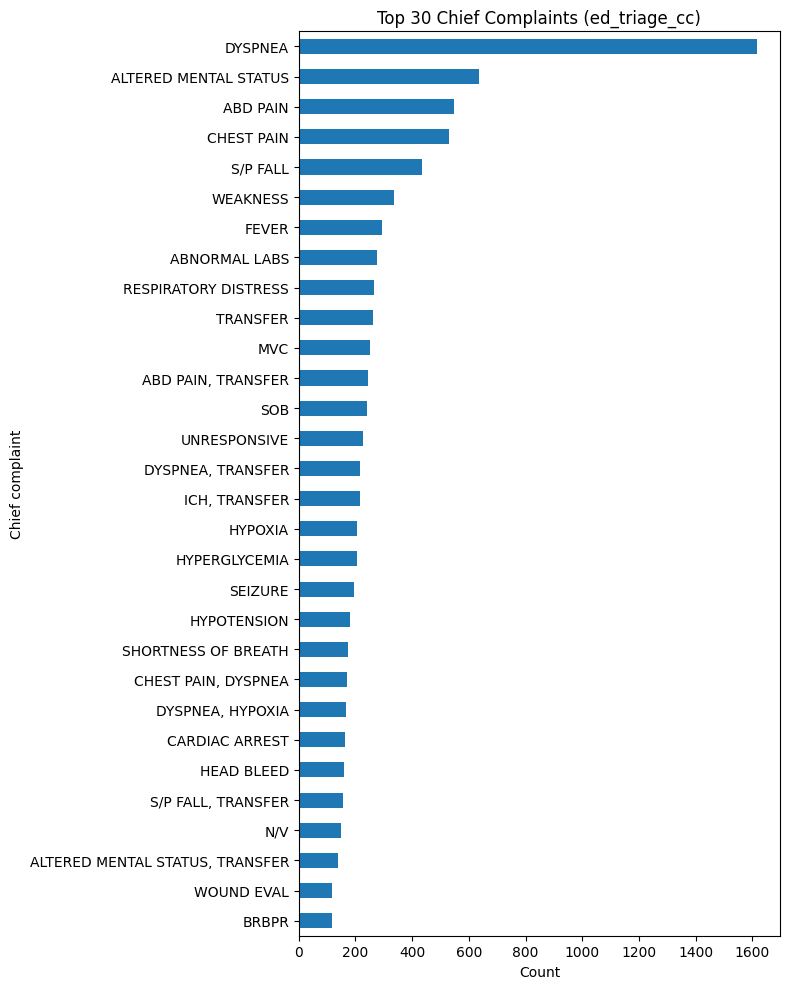

         chief_complaint  count
0                DYSPNEA   1617
1  ALTERED MENTAL STATUS    635
2               ABD PAIN    546
3             CHEST PAIN    529
4               S/P FALL    436
5               WEAKNESS    336
6                  FEVER    293
7          ABNORMAL LABS    275
8   RESPIRATORY DISTRESS    266
9               TRANSFER    262


In [9]:
import matplotlib.pyplot as plt

def top_cc_plot(
    df,
    candidates=('ed_triage_cc','chief_complaint','ed_chief_complaint','chiefcomplaint','cc'),
    top_n=30,
    normalize_case='upper'  # {'upper','title',None}
):
    cc_col = next((c for c in candidates if c in df.columns), None)
    if cc_col is None:
        raise KeyError(f"No chief-complaint column found in {candidates}.")

    s = (df[cc_col]
         .astype(str)
         .str.strip()
         .str.replace(r'\s+', ' ', regex=True))

    if normalize_case == 'upper':
        s = s.str.upper()
    elif normalize_case == 'title':
        s = s.str.title()

    vc = s.value_counts().head(top_n)
    vc = vc.sort_values(ascending=True)

    ax = vc.plot(kind='barh', figsize=(8, 10))
    ax.set_xlabel('Count')
    ax.set_ylabel('Chief complaint')
    ax.set_title(f'Top {top_n} Chief Complaints ({cc_col})')
    plt.tight_layout()
    plt.show()

    # also return the frequency table for programmatic use
    return vc.sort_values(ascending=False).rename_axis('chief_complaint').reset_index(name='count')

# usage:
freq_table = top_cc_plot(df, top_n=30, normalize_case='upper')
print(freq_table.head(10))

In [10]:
# --- Core dependencies and model ---
import re, sys, subprocess, importlib
import numpy as np
import pandas as pd

def _ensure(pkg, import_name=None):
    import_name = import_name or pkg
    try:
        importlib.import_module(import_name)
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", pkg])
        importlib.invalidate_caches()

_ensure("ftfy")
_ensure("symspellpy")
_ensure("spacy")

import ftfy, spacy
from symspellpy.symspellpy import SymSpell, Verbosity

# spaCy model
try:
    nlp = spacy.load("en_core_web_sm", disable=["ner","parser","textcat","senter"])
except OSError:
    subprocess.check_call([sys.executable, "-m", "spacy", "download", "en_core_web_sm"])
    nlp = spacy.load("en_core_web_sm", disable=["ner","parser","textcat","senter"])

# --- Config & curated overrides (minimal, extend as you like) ---
CC_CANDIDATES = (
    "ed_triage_cc","chief_complaint","ed_chief_complaint",
    "chiefcomplaint","chief_complaint_text","ed_cc","cc"
)

def get_cc_column(df: pd.DataFrame) -> str:
    for c in CC_CANDIDATES:
        if c in df.columns:
            return c
    raise KeyError(f"No chief-complaint column found in {CC_CANDIDATES}.")

PROTECT = ("n/v","n/v/d","s/p","w/","w/o","h/o","c/o")
MISSING_RE = re.compile(r"^(?:n/?a|na|none|unknown|unk|no chief complaint|no complaint|not applicable|not available)$", re.I)
NEG_RE     = re.compile(r"^(?:denies?|no|not|without|w/o)\b", re.I)

# curated segment- and token-level overrides
SEG_OVR = {
    "n/v":"nausea vomiting",
    "n/v/d":"nausea vomiting diarrhea",
    "nvd":"nausea vomiting diarrhea",
    "w/":"with", "w/o":"without", "s/p":"status post", "h/o":"history of", "c/o":"complains of",
    "mva":"motor vehicle accident", "mvc":"motor vehicle collision",
    "ped vs auto":"pedestrian struck by vehicle", "gsw":"gunshot wound",
    "sa":"sexual assault",
}
TOK_OVR = {
    # cardiopulmonary
    "sob":"shortness of breath","doe":"dyspnea on exertion","cp":"chest pain","palps":"palpitations",
    # neuro
    "ha":"headache","loc":"loss of consciousness","ams":"altered mental status",
    "sz":"seizure","szs":"seizure","cva":"stroke","tia":"transient ischemic attack",
    # gi/gu
    "abd":"abdominal", "abdo":"abdominal", "rlq":"right lower quadrant","ruq":"right upper quadrant",
    "llq":"left lower quadrant","luq":"left upper quadrant",
    "lbp":"low back pain","brbpr":"rectal bleeding",
    "uti":"urinary tract infection","dysuria":"painful urination","hematuria":"blood in urine",
    "nv":"nausea vomiting","nvd":"nausea vomiting diarrhea",
    # respiratory / infectious
    "sorethroat":"sore throat","uri":"upper respiratory infection","pna":"pneumonia","covid":"covid","flu":"influenza",
    # psych/substance
    "si":"suicidal ideation","hi":"homicidal ideation","avh":"auditory visual hallucinations",
    "etoh":"alcohol","od":"overdose","fb":"foreign body",
    # ob/gyn
    "vag":"vaginal","vb":"vaginal bleeding","hg":"hyperemesis gravidarum",
    # keep slash forms usable inside segments too
    "s/p":"status post","w/":"with","w/o":"without","h/o":"history of","c/o":"complains of",
    "n/v":"nausea vomiting","n/v/d":"nausea vomiting diarrhea",
}
# context overrides (eye vs overdose)
CTX_OVR = {
    "od": (lambda seg: not re.search(r"\b(eye|vision|ophth|ophthalm|cornea|ocular)\b", seg),
           "overdose", "right eye"),
    "os": (lambda seg: re.search(r"\b(eye|vision|ophth|ophthalm|cornea|ocular)\b", seg),
           "left eye", None),
    "ou": (lambda seg: re.search(r"\b(eye|vision|ophth|ophthalm|cornea|ocular)\b", seg),
           "both eyes", None),
}

# optional external abbreviation inventory; keep empty if offline
abbr_map: dict[str,str] = {}

# --- SymSpell (lightweight lexicon) ---
sym = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)
def _add_lexicon_from_phrases(phrases):
    for ph in phrases:
        for w in str(ph).split():
            if w.isalpha():
                sym.create_dictionary_entry(w, 1)

_add_lexicon_from_phrases(list(SEG_OVR.values()) + list(TOK_OVR.values()) + list(abbr_map.values()))

SAFE_2CHAR = {"cp","ha","nv","gi","gu","ms","sx","bp","hr","doe","sob","loc"}

def _spell(tok: str) -> str:
    if len(tok) <= 3 and tok not in SAFE_2CHAR:
        return tok
    if not tok.isalpha():
        return tok
    cand = sym.lookup(tok, Verbosity.CLOSEST, max_edit_distance=2)
    return cand[0].term if cand else tok

# --- Token/segment helpers used by normalize_cc ---
_PUNCT_EDGE = re.compile(r"(^[^\w/]+)|([^\w/]+$)")
def _clean_tok(tok: str) -> str:
    return _PUNCT_EDGE.sub("", tok)

def _expand_tokens(seg: str) -> str:
    """Contextual → curated → inventory token expansion inside a segment."""
    out = []
    seg_for_ctx = seg
    for tok in seg.split():
        t = _clean_tok(tok)
        if not t: 
            continue
        if t in CTX_OVR:
            pred, yes, no = CTX_OVR[t]
            if pred(seg_for_ctx):
                out.extend(yes.split()); continue
            if no:
                out.extend(no.split()); continue
        if t in TOK_OVR:
            out.extend(TOK_OVR[t].split()); continue
        if t in abbr_map:
            out.extend(abbr_map[t].split()); continue
        out.append(t)
    return " ".join(out)

# conditional split on "and" only when both sides look clinical
CLINICAL_KEYS = {
    "pain","fever","chill","cough","wheez","dyspnea","shortness","hemopty",
    "nausea","vomit","diarrhea","bleeding","rash","injury","wound","laceration","fracture",
    "sprain","assault","fall","seizure","syncope","weakness","numbness","tingling","headache",
    "dizziness","palpitation","chest","abdominal","flank","pelvic","back","neck","urinary",
    "dysuria","hematuria","pregnan","vaginal","overdose","intoxication","anxiety","depression",
    "psychosis","sore","throat","ear","eye","dental","asthma","copd","flu","covid","pneumonia"
}
def _looks_clinical(s: str) -> bool:
    s = s.lower()
    return any(k in s for k in CLINICAL_KEYS) and re.search(r"[a-z]", s)

def _split_on_and_if_clinical(seg: str) -> list[str]:
    parts = [p.strip() for p in re.split(r"\band\b", seg, flags=re.I)]
    if len(parts) == 1:
        return parts
    out, buf = [], parts[0]
    for nxt in parts[1:]:
        if _looks_clinical(buf) and _looks_clinical(nxt):
            out.append(buf.strip()); buf = nxt
        else:
            buf = f"{buf} and {nxt}"
    out.append(buf.strip())
    return out

# duration patterns: sobx2d, sob x 2 d, x3w, x2 months, etc.
_DUR_RE = re.compile(r"\b([a-z]{2,})\s*x\s*(\d{1,3})\s*([dhwm]|day|hr|hour|wk|week|mo|mon|month|yr|year)s?\b", re.I)
_UNIT = {
    "d":"days","day":"days","h":"hours","hr":"hours","hour":"hours",
    "w":"weeks","wk":"weeks","week":"weeks","m":"months","mo":"months","mon":"months",
    "y":"years","yr":"years","year":"years"
}
def _expand_duration(seg: str) -> str:
    def repl(m):
        base = m.group(1)
        n = m.group(2)
        key = m.group(3).lower()
        key = key[0]  # map by first letter via _UNIT
        return f"{base} for {n} {_UNIT.get(key,'')}".strip()
    return _DUR_RE.sub(repl, seg)

# primary splitter: separators ; , + &
SEP_SPLIT_RE = re.compile(r"\s*(?:[;:,]|[+&])\s*")

def segment_cc(raw: str, keep_negated: bool=False) -> list[str]:
    if not isinstance(raw, str) or not raw.strip():
        return []
    txt = ftfy.fix_text(raw).lower().strip()

    # Protect canonical slash tokens
    for p in PROTECT:
        txt = txt.replace(p, p.replace("/", "§"))

    # Normalize spaced variants so they become protected too
    txt = re.sub(r"\bn\s*/\s*v\s*/\s*d\b", "n§v§d", txt)  # n / v / d
    txt = re.sub(r"\bn\s*/\s*v\b",         "n§v",    txt)  # n / v
    txt = re.sub(r"\bs\s*/\s*p\b",         "s§p",    txt)  # s / p
    txt = re.sub(r"\bw\s*/\s*o\b",         "w§o",    txt)  # w / o
    txt = re.sub(r"\bh\s*/\s*o\b",         "h§o",    txt)  # h / o
    txt = re.sub(r"\bc\s*/\s*o\b",         "c§o",    txt)  # c / o

    # Split on any remaining slashes (true separators)
    txt = txt.replace("/", "; ")
    # <<< END INSERT >>>

    segs = []
    for block in SEP_SPLIT_RE.split(txt):
        if not block:
            continue
        block = block.replace("§", "/").strip()
        block = " ".join(block.split())
        if MISSING_RE.fullmatch(block):
            continue
        for seg in _split_on_and_if_clinical(block):
            if not seg:
                continue
            if not keep_negated and NEG_RE.match(seg):
                continue
            # drop single-letter noise like 'n','v','d' if they slipped through
            if re.fullmatch(r"[a-z]$", seg):
                continue
            segs.append(seg)
    return segs

def normalize_cc(raw: str, keep_negated: bool=False) -> list[str]:
    out, seen = [], set()
    for seg in segment_cc(raw, keep_negated=keep_negated):
        if seg in SEG_OVR:
            seg = SEG_OVR[seg]
        else:
            toks = seg.split()
            if len(toks) == 1:
                t = _clean_tok(toks[0])
                if t in TOK_OVR:
                    seg = TOK_OVR[t]
                else:
                    seg = abbr_map.get(seg, seg)
        seg = _expand_duration(seg)
        seg = _expand_tokens(seg)
        toks = [_spell(t) for t in seg.split()]
        seg = " ".join(t.lemma_ for t in nlp(" ".join(toks))).strip()
        if seg and seg not in seen:
            out.append(seg); seen.add(seg)
    return out

print("CC normalization stack ready.")

CC normalization stack ready.


In [11]:
# --- Deterministic RFV mapper (top-level groups) ---
from dataclasses import dataclass

PRECEDENCE = [
    "injury","resp","circ","neuro","gi","gu","msk","skin","eye_ear",
    "general","psych","disease","abn_test","screen","treatment","admin","uncodable"
]

@dataclass(frozen=True)
class Rule:
    group: str
    rx: re.Pattern

RULES = [
    Rule("injury", re.compile(r"\b(mvc|mva|collision|assault|fall|gsw|gunshot|stab|laceration|fracture|burn|overdose|poison|foreign body|fb)\b")),
    Rule("resp", re.compile(r"\b(shortness of breath|dyspnea|doe|wheeze|cough|hemoptysis|respiratory distress)\b")),
    Rule("circ", re.compile(r"\b(chest pain|(?:^|[^a-z])cp(?:[^a-z]|$)|palpitation|hypotension|low bp|edema|leg swelling|ankle swelling)\b")),
    Rule("neuro", re.compile(r"\b(headache|migraine|dizziness|syncope|weakness|numbness|tingling|seizure|altered mental status|ams|slurred speech|aphasia|facial droop)\b")),
    Rule("gi", re.compile(r"\b(abd(ominal)? pain|rlq|ruq|llq|luq|nausea|vomit|diarrhea|constipation|rectal bleeding|hematemesis|jaundice)\b")),
    Rule("gu", re.compile(r"\b(dysuria|hematuria|frequency|urgency|flank pain|pelvic pain|vaginal (bleeding|discharge)|penile discharge)\b")),
    Rule("msk", re.compile(r"\b(back pain|neck pain|shoulder pain|knee pain|hip pain|joint pain|arm pain|leg pain|gait)\b")),
    Rule("skin", re.compile(r"\b(rash|cellulitis|abscess|wound(?! check))\b")),
    Rule("eye_ear", re.compile(r"\b(eye pain|red eye|vision change|ear pain|hearing change|otitis|conjunctivitis)\b")),
    Rule("general", re.compile(r"\b(fever|chills|fatigue|malaise|weakness(?!.*focal))\b")),
    Rule("psych", re.compile(r"\b(anxiety|depression|insomnia|suicidal ideation|homicidal ideation|si|hi|psychosis|agitation)\b")),
    Rule("disease", re.compile(r"\b(asthma attack|copd flare|covid(?! test)|diabetes(?!.*test)|pneumonia|hypertensive crisis|stroke)\b")),
    Rule("abn_test", re.compile(r"\b(abnormal (lab|ecg|ekg|imaging)|told.*(abnormal|positive)|positive (strep|flu|covid) (result|test))\b")),
    Rule("screen", re.compile(r"\b(covid test|flu test|strep test|bp check|pregnancy test|workup|screen(ing)?)\b")),
    Rule("treatment", re.compile(r"\b(refill|medication refill|wound check|suture removal|dressing change|injection|detox clearance)\b")),
    Rule("admin", re.compile(r"\b(form|paperwork|note|letter|clearance|work (note|letter))\b")),
]

def assign_rfv(segments: list[str], max_rfv: int = 5):
    hits = []
    for i, seg in enumerate(segments):
        seg_l = " " + seg.lower() + " "
        for rule in RULES:
            if rule.rx.search(seg_l):
                hits.append((rule.group, i, seg))
                break
    # keep first support per group; order by precedence then text position
    first_support = {}
    for g, i, s in hits:
        first_support.setdefault(g, (i, s))
    ordered = sorted(first_support.items(), key=lambda kv: (PRECEDENCE.index(kv[0]), kv[1][0]))[:max_rfv]
    return [{"group": g, "support": first_support[g][1]} for g, _ in ordered]

print("RFV rules ready.")

RFV rules ready.


In [12]:
cc_col = get_cc_column(df)                      # prefers ed_triage_cc
df["cc_cleaned"] = df[cc_col].apply(normalize_cc)
df["cc_cleaned_str"] = df["cc_cleaned"].str.join("; ")

def map_row_to_rfv(row):
    segs = row["cc_cleaned"]
    rfv = assign_rfv(segs)
    out = {f"RFV{i+1}": (rfv[i]["group"] if i < len(rfv) else "") for i in range(5)}
    out.update({f"RFV{i+1}_support": (rfv[i]["support"] if i < len(rfv) else "") for i in range(5)})
    return pd.Series(out)

rfv_cols = df.apply(map_row_to_rfv, axis=1)
df = pd.concat([df, rfv_cols], axis=1)

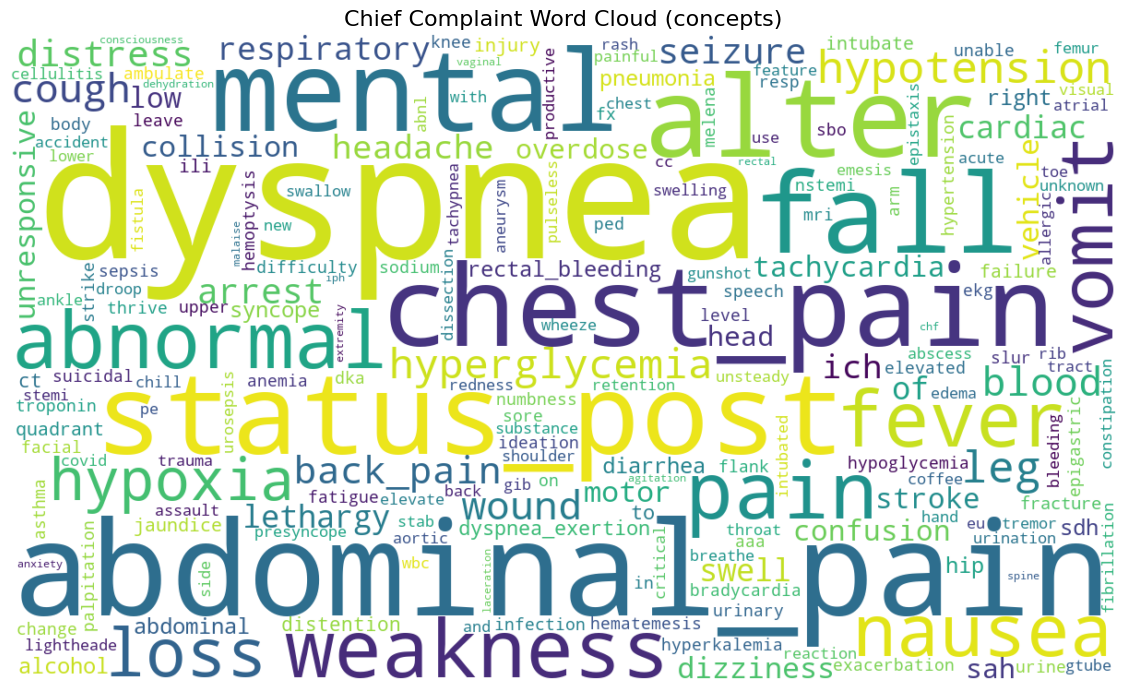

In [13]:
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re

# Concept-level replacements applied AFTER normalize_cc()
CANON_REPLACERS = [
    (re.compile(r"\bshortness of breath\b", flags=re.I), "dyspnea"),
    (re.compile(r"\bdyspneic?\b", flags=re.I),           "dyspnea"),
    (re.compile(r"\bdyspnea on exertion\b", flags=re.I), "dyspnea_exertion"),
]

# Optional: reduce noise from s/p
CANON_REPLACERS += [
    (re.compile(r"\bstatus post\b", flags=re.I), "status_post"),
]

def canonize_cc_segments(segments):
    if not isinstance(segments, list): 
        return segments
    out = []
    for seg in segments:
        t = seg
        for rx, rep in CANON_REPLACERS:
            t = rx.sub(rep, t)
        out.append(t)
    return out

# Apply on top of your existing cc_cleaned
df["cc_cleaned_canon"] = df["cc_cleaned"].apply(canonize_cc_segments)
df["cc_cleaned_canon_str"] = df["cc_cleaned_canon"].str.join("; ")



# Phrases to preserve in the cloud (add freely)
PHRASE_JOIN = [
    (re.compile(r"\baltered mental status\b", re.I), "altered_mental_status"),
    (re.compile(r"\bchest pain\b", re.I),            "chest_pain"),
    (re.compile(r"\babdominal pain\b", re.I),        "abdominal_pain"),
    (re.compile(r"\brectal bleeding\b", re.I),       "rectal_bleeding"),
    (re.compile(r"\bback pain\b", re.I),             "back_pain"),
    (re.compile(r"\bdyspnea\b", re.I),               "dyspnea"),             # concept token
    (re.compile(r"\bdyspnea_exertion\b", re.I),      "dyspnea_exertion"),
    (re.compile(r"\bstatus post\b", re.I),           "status_post"),         # optional
]

# Lightweight stoplist for visualization-only noise
CLOUD_STOP = {"status", "post", "transfer", "eval", "evaluation"}

def concept_frequencies(segments_series, lowercase=True):
    freq = Counter()
    for segs in segments_series:
        if not isinstance(segs, list): 
            continue
        for s in segs:
            # phrase joining
            for rx, repl in PHRASE_JOIN:
                s = rx.sub(repl, s)
            txt = s.lower() if lowercase else s
            # tokenize letters/underscores only
            for tok in re.findall(r"[a-zA-Z_]+", txt):
                if tok in CLOUD_STOP or len(tok) < 2:
                    continue
                freq[tok] += 1
    return freq

# Build frequencies from the canonicalized segments
freq = concept_frequencies(df["cc_cleaned_canon"])

# Word cloud that respects the joined phrases and concepts
wc = WordCloud(width=1200, height=700, background_color="white")
wc = wc.generate_from_frequencies(freq)

plt.figure(figsize=(12,7))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Chief Complaint Word Cloud (concepts)", fontsize=16)
plt.tight_layout()
plt.show()

In [14]:
import re, json, math
from dataclasses import dataclass
from collections import defaultdict, Counter

import torch
import pandas as pd
from sentence_transformers import SentenceTransformer, util

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
MODEL_NAME = "NeuML/bioclinical-modernbert-base-embeddings"  # SentenceTransformers-ready

encoder = SentenceTransformer(MODEL_NAME, device=DEVICE, trust_remote_code=True)

/opt/anaconda3/envs/mimiciv-tabular/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:
from pathlib import Path
from collections import defaultdict
import pandas as pd
import numpy as np
import torch
from sentence_transformers import util

APPX = Path("/Users/reblocke/Research/Hypercap-CC-NLP/Annotation/nhamcs_rvc_2022_appendixII_codes.csv")
SUMM = Path("/Users/reblocke/Research/Hypercap-CC-NLP/Annotation/nhamcs_rvc_2022_summary_by_top_level_17.csv")

# --- 17-group canon (same keys you already use) ---
RVC_NAME = {
    "RVC-INJ":"Injuries & adverse effects","RVC-SYM-RESP":"Symptom – Respiratory",
    "RVC-SYM-CIRC":"Symptom – Circulatory","RVC-SYM-NERV":"Symptom – Nervous",
    "RVC-SYM-DIG":"Symptom – Digestive","RVC-SYM-GU":"Symptom – Genitourinary",
    "RVC-SYM-MSK":"Symptom – Musculoskeletal","RVC-SYM-SKIN":"Symptom – Skin/Hair/Nails",
    "RVC-SYM-EYE":"Symptom – Eye/Ear","RVC-SYM-GEN":"Symptom – General",
    "RVC-SYM-PSY":"Symptom – Psychological","RVC-DIS":"Diseases (patient‑stated)",
    "RVC-TEST":"Abnormal test result","RVC-DIAG":"Diagnostic/Screening/Preventive",
    "RVC-TREAT":"Treatment/Medication","RVC-ADMIN":"Administrative","RVC-UNCL":"Uncodable/Unknown"
}

PRECEDENCE = [
    "RVC-INJ","RVC-SYM-RESP","RVC-SYM-CIRC","RVC-SYM-NERV","RVC-SYM-DIG",
    "RVC-SYM-GU","RVC-SYM-MSK","RVC-SYM-SKIN","RVC-SYM-EYE","RVC-SYM-GEN",
    "RVC-SYM-PSY","RVC-DIS","RVC-TEST","RVC-DIAG","RVC-TREAT","RVC-ADMIN","RVC-UNCL"
]  # NHAMCS ladder; used elsewhere too.  [oai_citation:2‡Annotators Guide v0.3 MIMIC IV Chief Complaint to NHAMCS RVS.docx](sediment://file_000000007a1c61f6b6fe2292fdae9011)

# --- Heuristics to detect columns in your spreadsheets ---
def _guess_col(cols, candidates):
    low = [c.lower().strip() for c in cols]
    for cand in candidates:
        if cand in low:
            return cols[low.index(cand)]
    return None

# --- Canonicalization / filtering for Appendix II phrases ---
RE_DROP = re.compile(r"\b(nec|nos|unspecified|other|other and unspecified)\b", re.I)
RE_SPACE = re.compile(r"\s+")
def canon_phrase(s: str) -> str:
    s = str(s).strip()
    s = s.replace("’","'").replace("–","-")
    s = RE_SPACE.sub(" ", s)
    s = s.strip(" .;:,")
    return s

def keep_phrase(s: str, group_code: str) -> bool:
    txt = s.lower()
    if len(txt) < 3: return False
    if RE_DROP.search(txt): return False
    # Filter body-part only entries unless in INJ/MSK/EYE/SKIN where site may carry signal
    if group_code not in {"RVC-INJ","RVC-SYM-MSK","RVC-SYM-EYE","RVC-SYM-SKIN"}:
        if re.fullmatch(r"(arm|leg|back|knee|hip|wrist|elbow|ankle|hand|foot|toe|finger|eye|ear)", txt):
            return False
    return True

# --- Map a free-text group label to your 17 keys (robust) ---
GROUP_MAP = [
    (re.compile(r"\binjur|poison|overdose|adverse effect", re.I), "RVC-INJ"),
    (re.compile(r"\brespir", re.I), "RVC-SYM-RESP"),
    (re.compile(r"\bcircul|cardio|lymph", re.I), "RVC-SYM-CIRC"),
    (re.compile(r"\bnerv|neuro", re.I), "RVC-SYM-NERV"),
    (re.compile(r"\bdigest|gastro|abd", re.I), "RVC-SYM-DIG"),
    (re.compile(r"\bgenitour|urinar|renal|pelvic|vagin|penil|breast", re.I), "RVC-SYM-GU"),
    (re.compile(r"\bmusculoskelet|msk|joint|back|neck", re.I), "RVC-SYM-MSK"),
    (re.compile(r"\bskin|hair|nail|derma", re.I), "RVC-SYM-SKIN"),
    (re.compile(r"\beye|ear|vision|hearing|vertigo", re.I), "RVC-SYM-EYE"),
    (re.compile(r"\bgeneral|fever|malaise|weakness", re.I), "RVC-SYM-GEN"),
    (re.compile(r"\bpsych|mental", re.I), "RVC-SYM-PSY"),
    (re.compile(r"\bdisease|diagnos|known|asthma|copd|diabetes|hypertens|pneumonia|stroke", re.I), "RVC-DIS"),
    (re.compile(r"\babnormal .*test|abnormal (lab|imaging|ekg|ecg)|positive (test|culture|result)", re.I), "RVC-TEST"),
    (re.compile(r"\bscreen|diagnostic|prenatal|immuniz|vaccine|bp check|test\b", re.I), "RVC-DIAG"),
    (re.compile(r"\btreat|medicat|refill|suture|dressing|injection|therapy|wound check", re.I), "RVC-TREAT"),
    (re.compile(r"\badmin|paperwork|form|clearance|insurance|work (note|letter)", re.I), "RVC-ADMIN"),
    (re.compile(r"\buncodable|unknown|illegible|none", re.I), "RVC-UNCL"),
]

def map_group(label: str) -> str|None:
    for rx, code in GROUP_MAP:
        if rx.search(str(label)):
            return code
    return None

# --- Load Appendix II and Summary files robustly ---
# map RVC display label -> code (normalize whitespace and dashes)
def _norm_label(s: str) -> str:
    s = (s or "").strip().lower()
    s = s.replace("–","-").replace("—","-")
    s = re.sub(r"\s+", " ", s)
    return s

LABEL2CODE = { _norm_label(v): k for k, v in RVC_NAME.items() }

def _label_to_code(label: str) -> str|None:
    lab = _norm_label(label)
    if lab in LABEL2CODE:
        return LABEL2CODE[lab]
    # fallback to regex mapping if a label differs slightly
    return map_group(label)

def load_appendix_phrases(path: Path) -> pd.DataFrame:
    if not path.exists():
        print(f"NOTE: Appendix not found at {path}; proceeding with curated seeds only.")
        return pd.DataFrame(columns=["group_code","phrase"])

    df = pd.read_csv(path, dtype=str)

    # Use the known columns
    if not {"top_level_group17","text"}.issubset(df.columns):
        # fall back to the generic heuristic if needed
        gcol = _guess_col(df.columns, ["top_level_group17","group","top_level_group","rvc_group","module"]) or "group"
        pcol = _guess_col(df.columns, ["text","phrase","subentry","entry","label"]) or "text"
    else:
        gcol, pcol = "top_level_group17", "text"

    df = df[[gcol, pcol]].rename(columns={gcol:"group_raw", pcol:"phrase_raw"})
    df["group_code"] = df["group_raw"].map(_label_to_code)
    df = df[df["group_code"].notna()]

    df["phrase"] = df["phrase_raw"].map(canon_phrase)
    df = df[df.apply(lambda r: keep_phrase(r["phrase"], r["group_code"]), axis=1)]
    return df[["group_code","phrase"]].drop_duplicates()

def load_summary_weights(path: Path, strategy: str = "uniform") -> dict[str, float]:
    """
    strategy: 'uniform' or 'by_rows'
      - 'uniform': all groups weight=1.0
      - 'by_rows': weight ∝ number of rows in this file per group (proxy, not prevalence)
    """
    if not path.exists():
        return {}
    df = pd.read_csv(path, dtype=str)

    # Robust group column detection
    gcol = _guess_col(df.columns, ["top_level_group17","group","top_level_group","rvc_group","module"])
    if not gcol:
        # fall back to first col if nothing matched
        gcol = df.columns[0]

    if strategy == "by_rows":
        w = df.groupby(gcol).size()
    else:
        # uniform
        w = df.groupby(gcol).size()
        w[:] = 1.0

    # log-scale and normalize to [~0,1]
    w = (np.log1p(w) / np.log1p(w).max()).to_dict()
    return w

appx_df = load_appendix_phrases(APPX) if APPX.exists() else pd.DataFrame(columns=["group_code","phrase"])
group_weights = load_summary_weights(SUMM)

# --- Start with your curated prototypes, then augment from Appendix II ---
RVC_PROTOS_CURATED = {
    "RVC-INJ": [
        "injury: laceration cut", "injury: fracture", "injury: burn", "injury: contusion bruise",
        "injury: foreign body", "injury: motor vehicle collision", "injury: fall",
        "adverse effect: medication reaction", "poisoning overdose", "injury: assault", "gunshot wound",
    ],
    "RVC-SYM-RESP": [
        "respiratory symptom: shortness of breath dyspnea", "respiratory symptom: dyspnea on exertion",
        "respiratory symptom: wheeze", "respiratory symptom: cough", "respiratory symptom: hemoptysis",
        "respiratory symptom: sputum production", "respiratory symptom: respiratory distress",
    ],
    "RVC-SYM-CIRC": [
        "circulatory symptom: chest pain suspected cardiac", "circulatory symptom: palpitations",
        "circulatory symptom: hypotension low blood pressure", "circulatory symptom: bradycardia",
        "circulatory symptom: tachycardia", "circulatory symptom: peripheral edema leg swelling ankle swelling",
        "circulatory symptom: claudication",
    ],
    "RVC-SYM-NERV": [
        "neurologic symptom: altered mental status confusion", "neurologic symptom: lethargy decreased responsiveness",
        "neurologic symptom: slurred speech dysarthria", "neurologic symptom: aphasia word finding difficulty",
        "neurologic symptom: facial droop", "neurologic symptom: syncope fainting", "neurologic symptom: seizure",
        "neurologic symptom: headache", "neurologic symptom: dizziness vertigo",
        "neurologic symptom: numbness tingling focal weakness",
    ],
    "RVC-SYM-DIG": [
        "digestive symptom: abdominal pain", "digestive symptom: nausea vomiting", "digestive symptom: diarrhea",
        "digestive symptom: rectal bleeding", "digestive symptom: dysphagia", "digestive symptom: jaundice",
    ],
    "RVC-SYM-GU": [
        "genitourinary symptom: dysuria painful urination", "genitourinary symptom: urinary frequency urgency",
        "genitourinary symptom: hematuria blood in urine", "genitourinary symptom: flank pain",
        "genitourinary symptom: pelvic pain", "genitourinary symptom: vaginal discharge",
    ],
    "RVC-SYM-MSK": [
        "musculoskeletal symptom: back pain", "musculoskeletal symptom: neck pain", "musculoskeletal symptom: joint pain",
        "musculoskeletal symptom: hip knee shoulder pain", "musculoskeletal symptom: gait problem",
    ],
    "RVC-SYM-SKIN": [
        "skin symptom: rash", "skin symptom: pruritus itching", "skin symptom: cellulitis redness warmth",
        "skin symptom: nontraumatic wound",
    ],
    "RVC-SYM-EYE": [
        "eye symptom: eye pain", "eye symptom: red eye eye redness", "eye symptom: blurry vision vision loss",
        "ear symptom: ear pain discharge", "vestibular symptom: vertigo spinning",
    ],
    "RVC-SYM-GEN": [
        "general symptom: fever chills", "general symptom: fatigue malaise", "general symptom: weakness generalized",
        "general symptom: weight change", "general symptom: edema swelling",
    ],
    "RVC-SYM-PSY": [
        "psychological symptom: anxiety", "psychological symptom: depression", "psychological symptom: agitation",
        "psychological symptom: insomnia", "psychological symptom: suicidal ideation", "psychological symptom: homicidal ideation",
        "psychological symptom: substance intoxication without overdose",
    ],
    "RVC-DIS": [
        "patient stated diagnosis: asthma attack", "patient stated diagnosis: copd flare", "patient stated diagnosis: pneumonia",
        "patient stated diagnosis: diabetes problem", "patient stated diagnosis: hypertensive crisis", "patient stated diagnosis: stroke diagnosed",
    ],
    "RVC-TEST": [
        "abnormal test: abnormal laboratory result", "abnormal test: abnormal imaging result",
        "abnormal test: positive culture", "abnormal test: abnormal ecg ekg", "abnormal test: positive blood culture",
    ],
    "RVC-DIAG": [
        "diagnostic screening: needs covid test", "diagnostic screening: blood pressure check",
        "diagnostic screening: routine testing screening", "diagnostic screening: prenatal check",
    ],
    "RVC-TREAT": [
        "treatment medication: prescription refill", "treatment medication: dressing change",
        "treatment medication: injection therapy", "treatment medication: suture removal", "treatment: wound check",
    ],
    "RVC-ADMIN": [
        "administrative reason: work form school form insurance paperwork", "administrative reason: clearance note",
    ],
    "RVC-UNCL": [
        "uncodable or unknown reason"
    ],
}
# Ensure every group exists (defensive)
for g in RVC_NAME:
    RVC_PROTOS_CURATED.setdefault(g, [])

# --- Merge curated seeds + Appendix II phrases ---
RVC_PROTOS_AUG = {g: list(v) for g,v in RVC_PROTOS_CURATED.items()}
for g, subdf in appx_df.groupby("group_code"):
    RVC_PROTOS_AUG[g].extend(subdf["phrase"].tolist())


# --- Deduplicate near-duplicates using embeddings (cosine > 0.92 collapses) ---
def dedup_prototypes(rvc_protos: dict[str,list[str]], sim_thresh: float = 0.92) -> dict[str,list[str]]:
    out = {}
    for g, phrases in rvc_protos.items():
        phrases = [canon_phrase(p) for p in phrases]
        phrases = sorted(list(dict.fromkeys(phrases)))  # exact dedup, stable order
        if not phrases:
            out[g] = []
            continue
        with torch.inference_mode():
            emb = encoder.encode(phrases, convert_to_tensor=True, normalize_embeddings=True, batch_size=256)
        keep = []
        taken = torch.zeros(len(phrases), dtype=torch.bool)
        for i in range(len(phrases)):
            if taken[i]: continue
            keep.append(phrases[i])
            if len(phrases) == 1: break
            # mark near-duplicates
            sims = util.cos_sim(emb[i:i+1], emb).squeeze(0).cpu().numpy()
            dup_idx = np.where(sims >= sim_thresh)[0]
            taken[dup_idx] = True
        out[g] = keep
    return out

RVC_PROTOS_FINAL = dedup_prototypes(RVC_PROTOS_AUG, sim_thresh=0.92)

# --- Encode final prototypes once; also compute optional weights per-prototype ---
ALL_PROTO_TEXTS, PROTO2CODE = [], []
for code, plist in RVC_PROTOS_FINAL.items():
    for p in plist:
        # Make short descriptors more uniform for embedding space
        if ":" in p:
            text = p
        else:
            # prefix with group cue (helps ModernBERT slightly)
            prefix = RVC_NAME[code].split("–")[0].strip()
            text = f"{prefix.lower()}: {p}"
        ALL_PROTO_TEXTS.append(text)
        PROTO2CODE.append(code)

with torch.inference_mode():
    PROTO_EMB = encoder.encode(ALL_PROTO_TEXTS, convert_to_tensor=True, normalize_embeddings=True, batch_size=256)

# Optional: a weight per prototype = group prior * 1 (uniform inside group)
PROTO_WEIGHT = np.ones(len(PROTO2CODE), dtype="float32")
if group_weights:
    for i, g in enumerate(PROTO2CODE):
        PROTO_WEIGHT[i] = max(1e-3, float(group_weights.get(g, 1.0)))  # log-scaled prior

# Build index lists per group for scoring
from collections import defaultdict
CODE2PROTOIDX = defaultdict(list)
for i, code in enumerate(PROTO2CODE):
    CODE2PROTOIDX[code].append(i)

In [16]:
import re, numpy as np, pandas as pd, torch
from sentence_transformers import util
from collections import defaultdict

# ---------- helpers from your earlier block (unchanged) ----------
def _guess_col(cols, candidates):
    low = [c.lower().strip() for c in cols]
    for cand in candidates:
        if cand in low:
            return cols[low.index(cand)]
    return None

RE_DROP  = re.compile(r"\b(nec|nos|unspecified|other|other and unspecified)\b", re.I)
RE_SPACE = re.compile(r"\s+")
def canon_phrase(s: str) -> str:
    s = str(s).strip().replace("’","'").replace("–","-")
    s = RE_SPACE.sub(" ", s).strip(" .;:,")
    return s

def keep_phrase(s: str, group_code: str) -> bool:
    txt = s.lower()
    if len(txt) < 3: return False
    if RE_DROP.search(txt): return False
    if group_code not in {"RVC-INJ","RVC-SYM-MSK","RVC-SYM-EYE","RVC-SYM-SKIN"}:
        if re.fullmatch(r"(arm|leg|back|knee|hip|wrist|elbow|ankle|hand|foot|toe|finger|eye|ear)", txt):
            return False
    return True

GROUP_MAP = [
    (re.compile(r"\binjur|poison|overdose|adverse effect", re.I), "RVC-INJ"),
    (re.compile(r"\brespir", re.I), "RVC-SYM-RESP"),
    (re.compile(r"\bcircul|cardio|lymph", re.I), "RVC-SYM-CIRC"),
    (re.compile(r"\bnerv|neuro", re.I), "RVC-SYM-NERV"),
    (re.compile(r"\bdigest|gastro|abd", re.I), "RVC-SYM-DIG"),
    (re.compile(r"\bgenitour|urinar|renal|pelvic|vagin|penil|breast", re.I), "RVC-SYM-GU"),
    (re.compile(r"\bmusculoskelet|msk|joint|back|neck", re.I), "RVC-SYM-MSK"),
    (re.compile(r"\bskin|hair|nail|derma", re.I), "RVC-SYM-SKIN"),
    (re.compile(r"\beye|ear|vision|hearing|vertigo", re.I), "RVC-SYM-EYE"),
    (re.compile(r"\bgeneral|fever|malaise|weakness", re.I), "RVC-SYM-GEN"),
    (re.compile(r"\bpsych|mental", re.I), "RVC-SYM-PSY"),
    (re.compile(r"\bdisease|diagnos|known|asthma|copd|diabetes|hypertens|pneumonia|stroke", re.I), "RVC-DIS"),
    (re.compile(r"\babnormal .*test|abnormal (lab|imaging|ekg|ecg)|positive (test|culture|result)", re.I), "RVC-TEST"),
    (re.compile(r"\bscreen|diagnostic|prenatal|immuniz|vaccine|bp check|test\b", re.I), "RVC-DIAG"),
    (re.compile(r"\btreat|medicat|refill|suture|dressing|injection|therapy|wound check", re.I), "RVC-TREAT"),
    (re.compile(r"\badmin|paperwork|form|clearance|insurance|work (note|letter)", re.I), "RVC-ADMIN"),
    (re.compile(r"\buncodable|unknown|illegible|none", re.I), "RVC-UNCL"),
]
def map_group(label: str) -> str|None:
    for rx, code in GROUP_MAP:
        if rx.search(str(label)): return code
    return None

def load_appendix_phrases(path: Path) -> pd.DataFrame:
    if not path.exists():
        print(f"NOTE: Appendix not found at {path}; proceeding with curated seeds only.")
        return pd.DataFrame(columns=["group_code","phrase"])
    df = pd.read_csv(path, dtype=str)
    gcol = _guess_col(df.columns, ["group","top_level_group","rvc_group","module"]) or "group"
    pcol = _guess_col(df.columns, ["phrase","subentry","entry","text","label"]) or "phrase"
    df = df[[gcol,pcol]].rename(columns={gcol:"group_raw", pcol:"phrase_raw"})
    df["group_code"] = df["group_raw"].map(map_group)
    df = df[df["group_code"].notna()]
    df["phrase"] = df["phrase_raw"].map(canon_phrase)
    df = df[df.apply(lambda r: keep_phrase(r["phrase"], r["group_code"]), axis=1)]
    return df[["group_code","phrase"]].drop_duplicates()

def load_summary_weights(path: Path, strategy: str = "uniform") -> dict[str, float]:
    """
    strategy: 'uniform' or 'by_rows'
      - 'uniform': all groups weight=1.0
      - 'by_rows': weight ∝ number of rows in this file per group (proxy, not prevalence)
    """
    if not path.exists():
        return {}
    df = pd.read_csv(path, dtype=str)

    # Robust group column detection
    gcol = _guess_col(df.columns, ["top_level_group17","group","top_level_group","rvc_group","module"])
    if not gcol:
        # fall back to first col if nothing matched
        gcol = df.columns[0]

    if strategy == "by_rows":
        w = df.groupby(gcol).size()
    else:
        # uniform
        w = df.groupby(gcol).size()
        w[:] = 1.0

    # log-scale and normalize to [~0,1]
    w = (np.log1p(w) / np.log1p(w).max()).to_dict()
    return w

# Merge curated + appendix
appx_df       = load_appendix_phrases(APPX)
group_weights = load_summary_weights(SUMM, strategy="uniform")  # or 'by_rows'

RVC_PROTOS_AUG = {g: list(v) for g, v in RVC_PROTOS_CURATED.items()}
for g, sub in appx_df.groupby("group_code"):
    RVC_PROTOS_AUG[g].extend(sub["phrase"].tolist())

# Deduplicate per group using embeddings
def dedup_prototypes(rvc_protos: dict[str,list[str]], sim_thresh=0.92):
    out = {}
    for g, phrases in rvc_protos.items():
        phrases = sorted(list(dict.fromkeys(canon_phrase(p) for p in phrases)))
        if not phrases:
            out[g] = []
            continue
        with torch.inference_mode():
            emb = encoder.encode(phrases, convert_to_tensor=True, normalize_embeddings=True, batch_size=256)
        keep, taken = [], torch.zeros(len(phrases), dtype=torch.bool)
        for i in range(len(phrases)):
            if taken[i]: continue
            keep.append(phrases[i])
            sims = util.cos_sim(emb[i:i+1], emb).squeeze(0).cpu().numpy()
            dup_idx = np.where(sims >= sim_thresh)[0]
            taken[dup_idx] = True
        out[g] = keep
    return out

RVC_PROTOS_FINAL = dedup_prototypes(RVC_PROTOS_AUG, sim_thresh=0.92)

# Encode final prototypes and build indices
ALL_PROTO_TEXTS, PROTO2CODE = [], []
for code, plist in RVC_PROTOS_FINAL.items():
    for p in plist:
        if ":" in p:
            text = p
        else:
            prefix = RVC_NAME[code].split("–")[0].strip().lower()
            text = f"{prefix}: {p}"
        ALL_PROTO_TEXTS.append(text)
        PROTO2CODE.append(code)

with torch.inference_mode():
    PROTO_EMB = encoder.encode(ALL_PROTO_TEXTS, convert_to_tensor=True, normalize_embeddings=True, batch_size=256)

PROTO_WEIGHT = np.ones(len(PROTO2CODE), dtype="float32")
if group_weights:
    for i, g in enumerate(PROTO2CODE):
        PROTO_WEIGHT[i] = max(1e-3, float(group_weights.get(g, 1.0)))

from collections import defaultdict
CODE2PROTOIDX = defaultdict(list)
for i, code in enumerate(PROTO2CODE):
    CODE2PROTOIDX[code].append(i)

def sanity_prototypes():
    counts = {g: len(CODE2PROTOIDX.get(g, [])) for g in RVC_NAME}
    total  = sum(counts.values())
    print("prototype count by group:", counts)
    print("TOTAL prototypes:", total, "PROTO_EMB shape:", tuple(PROTO_EMB.shape))
    missing = [g for g,c in counts.items() if c == 0]
    assert not missing, f"Groups missing prototypes: {missing}"
    assert total >= 50, f"Too few prototypes ({total}). Check paths and seeds."

sanity_prototypes()

prototype count by group: {'RVC-INJ': 75, 'RVC-SYM-RESP': 7, 'RVC-SYM-CIRC': 7, 'RVC-SYM-NERV': 10, 'RVC-SYM-DIG': 6, 'RVC-SYM-GU': 6, 'RVC-SYM-MSK': 5, 'RVC-SYM-SKIN': 4, 'RVC-SYM-EYE': 5, 'RVC-SYM-GEN': 5, 'RVC-SYM-PSY': 6, 'RVC-DIS': 135, 'RVC-TEST': 4, 'RVC-DIAG': 12, 'RVC-TREAT': 54, 'RVC-ADMIN': 14, 'RVC-UNCL': 6}
TOTAL prototypes: 361 PROTO_EMB shape: (361, 768)


In [17]:
# Precompiled regex triggers per group
RX_FOCAL_WEAK = re.compile(
    r"\b(focal|left|right|arm|leg|hand|face|hemiparesis|hemiplegia).*\bweakness\b|\bweakness\b.*\b(focal|left|right|arm|leg|hand|face)\b",
    re.I
)

RX = {
    "RVC-INJ": re.compile(r"\b(mvc|mva|collision|ped(\s|)vs(\s|)auto|assault|fell|fall|gsw|gunshot|stab|laceration|fracture|burn|foreign body|poison(ing)?|overdose|od\b|adverse (drug|medication) reaction)\b", re.I),
    "RVC-SYM-RESP": re.compile(r"\b(shortness of breath|dyspnea|doe\b|wheeze|respiratory distress|cough(ing)?|hemoptysis|sputum)\b", re.I),
    "RVC-SYM-CIRC": re.compile(r"\b(chest pain|palpitation(s)?|hypotension|low bp|bradycardia|tachycardia|arrhythmia|irregular heartbeat|edema|leg swelling|ankle swelling|peripheral edema|claudication)\b", re.I),
    "RVC-SYM-NERV": re.compile(r"\b(alter(ed)? mental status|ams\b|confusion|letharg(y|ic)|unresponsive|syncope|faint(ing)?|seizure(s)?|slurred speech|dysarthria|aphasia|facial droop|headache|migraine|dizziness|vertigo|numbness|tingling)\b", re.I),
    "RVC-SYM-DIG":  re.compile(r"\b(abd(ominal)? pain|abdo pain|nausea|vomit(ting)?|diarrhea|rectal bleeding|hematemesis|dysphagia|jaundice)\b", re.I),
    "RVC-SYM-GU":   re.compile(r"\b(dysuria|hematuria|urinary (frequency|urgency)|flank pain|pelvic pain|vaginal (bleeding|discharge)|penile discharge)\b", re.I),
    "RVC-SYM-MSK":  re.compile(r"\b(back pain|neck pain|shoulder pain|knee pain|hip pain|joint pain|gait problem)\b", re.I),
    "RVC-SYM-SKIN": re.compile(r"\b(rash|pruritus|itch(ing)?|cellulitis|wound(?! check))\b", re.I),
    "RVC-SYM-EYE":  re.compile(r"\b(eye (pain|redness|irritation)|red eye|pink ?eye|conjunctivitis|blurry vision|vision (loss|change)|ear pain|hearing (loss|change)|tinnitus|ear discharge|vertigo)\b", re.I),
    "RVC-SYM-GEN":  re.compile(r"\b(fever|chills|fatigue|malaise|weakness(?!.*focal))\b", re.I),
    "RVC-SYM-PSY":  re.compile(r"\b(anxiety|depression|insomnia|agitation|suicidal ideation|homicidal ideation|si\b|hi\b|intoxication)\b", re.I),
    "RVC-DIS":      re.compile(r"\b(asthma attack|copd flare|pneumonia|diabetes(?!.*test)|hypertensive crisis|stroke diagnosed)\b", re.I),
    "RVC-TEST":     re.compile(r"\b(abnormal (lab|labs|imaging|ct|mri|x[- ]?ray|ekg|ecg)|told (to come|results?)|positive (test|culture|blood culture)|blood culture (positive|grew|growth))\b", re.I),
    "RVC-DIAG":     re.compile(r"\b((needs|for) (covid|flu|strep) test|screen(ing)?|bp (check|recheck)|workup|routine testing|prenatal)\b", re.I),
    "RVC-TREAT":    re.compile(r"\b(refill|prescription refill|rx refill|dressing change|suture removal|injection|detox clearance|wound check)\b", re.I),
    "RVC-ADMIN":    re.compile(r"\b(form|paperwork|note|letter|clearance|insurance|work (note|letter))\b", re.I),
}

# Apply rules to one segment (normalized text)
def rule_gate(segment: str) -> tuple[str|None, list[str]]:
    s = " " + segment.lower() + " "
    # Neuro vs General for "weakness"
    if "weakness" in s and RX_FOCAL_WEAK.search(s):
        return "RVC-SYM-NERV", ["focal weakness"]

    hits = []
    for code, rx in RX.items():
        if rx.search(s):
            hits.append(code)
    if not hits:
        return None, []

    # precedence-based selection when multiple rules hit
    for pref in PRECEDENCE:
        if pref in hits:
            return pref, [pref]
    return hits[0], [hits[0]]

In [18]:
# Build a cache of unique segment embeddings and precompute prototype sims
# Requires: encoder, PROTO_EMB, CODE2PROTOIDX, (optional) PROTO_WEIGHT
import numpy as np
import torch
from dataclasses import dataclass
from sentence_transformers import util

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

@dataclass
class SegmentEmbedCache:
    uniq_segments: list[str]                  # sorted unique segments
    seg2idx: dict[str, int]                   # segment -> row index in sim matrix
    emb: torch.Tensor                         # [N_uniq, D] normalized embeddings
    sim_proto: torch.Tensor                   # [N_uniq, N_proto] cosine sims vs prototypes

def build_segment_cache(df, seg_col="cc_cleaned", batch_size=512) -> SegmentEmbedCache:
    uniq = []
    seen = set()
    for val in df[seg_col]:
        if isinstance(val, list):
            for s in val:
                s = str(s).strip()
                if s and s not in seen:
                    uniq.append(s); seen.add(s)
        elif isinstance(val, str):
            s = val.strip()
            if s and s not in seen:
                uniq.append(s); seen.add(s)
    uniq.sort()
    if not uniq:
        # empty cache
        return SegmentEmbedCache([], {}, torch.empty(0,0), torch.empty(0,0))

    with torch.inference_mode():
        emb = encoder.encode(uniq, convert_to_tensor=True, normalize_embeddings=True, batch_size=batch_size, device=DEVICE)
        # ensure unit norm (should already be)
        emb = torch.nn.functional.normalize(emb, p=2, dim=1)
        sim_proto = emb @ PROTO_EMB.T  # cosine because both are normalized

    seg2idx = {s: i for i, s in enumerate(uniq)}
    return SegmentEmbedCache(uniq, seg2idx, emb, sim_proto)

# Group-scoring using precomputed proto sims (method = "max" or "lse")
import math

def group_scores_from_proto_row(proto_row, method="lse", alpha=12.0):
    # proto_row: 1D tensor or numpy array of sims for this segment against all prototypes
    v = proto_row.detach().cpu().numpy() if isinstance(proto_row, torch.Tensor) else np.asarray(proto_row)
    scores = {}
    for g, idxs in CODE2PROTOIDX.items():
        vv = v[idxs]
        if method == "max":
            s = float(vv.max(initial=-1.0))
        else:
            # log-sum-exp with optional per-group prior weights
            w = PROTO_WEIGHT[idxs] if 'PROTO_WEIGHT' in globals() and isinstance(PROTO_WEIGHT, np.ndarray) else np.ones_like(vv)
            z = alpha * vv + np.log(w)
            m = z.max()
            s = float(m + np.log(np.exp(z - m).sum()))
        scores[g] = s
    if method != "max":
        # min-max normalize for comparability
        mx, mn = max(scores.values()), min(scores.values())
        rng = (mx - mn) if mx > mn else 1.0
        for g in scores: scores[g] = (scores[g] - mn) / rng
    return scores

In [19]:
# Max‑over‑(segment×prototypes) similarity per group for THIS segment

def score_one_segment_soft(segment: str, alpha: float = 12.0) -> dict[str,float]:
    """alpha: temperature; higher -> closer to max; lower -> smoother pooling."""
    if not isinstance(segment, str) or not segment.strip():
        return {g: -1.0 for g in RVC_NAME.keys()}
    with torch.inference_mode():
        seg_emb = encoder.encode([segment], convert_to_tensor=True, normalize_embeddings=True)
        sim = util.cos_sim(seg_emb, PROTO_EMB).squeeze(0).cpu().numpy()  # (n_prototypes,)
    scores = {}
    for g, idxs in CODE2PROTOIDX.items():
        v = sim[idxs]
        w = PROTO_WEIGHT[idxs] if isinstance(PROTO_WEIGHT, np.ndarray) else np.ones_like(v)
        z = alpha * v + np.log(w)
        m = z.max()
        scores[g] = float(m + np.log(np.exp(z - m).sum()))  # log-sum-exp
    # optional: normalize to [0,1] for readability
    mx, mn = max(scores.values()), min(scores.values())
    rng = (mx - mn) if mx > mn else 1.0
    for g in scores: scores[g] = (scores[g] - mn) / rng
    return scores

@dataclass
class SegPred:
    seg_idx: int
    segment: str
    code: str
    name: str
    sim: float
    rule_code: str|None
    rule_used: bool

# Classify all segments of one row
def classify_segments(segments: list[str],
                      abstain: float = 0.40) -> list[SegPred]:
    preds: list[SegPred] = []
    for i, seg in enumerate(segments):
        override, _ = rule_gate(seg)
        scores = score_one_segment_soft(seg)
        code, sim = max(scores.items(), key=lambda kv: kv[1])

        # If a rule fires, prefer it (manual is prescriptive for these cases)
        if override is not None:
            code = override

        if sim < abstain and override is None:
            code = "RVC-UNCL"

        preds.append(SegPred(i, seg, code, RVC_NAME.get(code, code), float(sim), override, override is not None))
    return preds

# Uses your existing: rule_gate(...), SegPred dataclass, RVC_NAME
def classify_segments_cached(segments: list[str], cache: SegmentEmbedCache,
                             abstain: float = 0.40, method: str = "max") -> list[SegPred]:
    preds = []
    for i, seg in enumerate(segments):
        s = str(seg).strip()
        if not s:
            continue

        override, _ = rule_gate(s)  # your rules
        if s in cache.seg2idx:
            idx = cache.seg2idx[s]
            proto_row = cache.sim_proto[idx]    # [N_proto]
            scores = group_scores_from_proto_row(proto_row, method=method)
        else:
            # rare fallback if segment not in cache (e.g., late rows)
            scores = score_one_segment(s)

        code, sim = max(scores.items(), key=lambda kv: kv[1])
        if override is not None:
            code = override
        if sim < abstain and override is None:
            code = "RVC-UNCL"

        preds.append(SegPred(i, s, code, RVC_NAME.get(code, code), float(sim), override, override is not None))
    return preds

In [20]:
def rfv_from_segment_preds(segpreds: list[SegPred], max_rfv: int = 5):
    # keep earliest provenance per group and maximum similarity (for reporting)
    first_pos, best_sim, support = {}, {}, {}
    for sp in segpreds:
        g = sp.code
        if g == "RVC-UNCL": 
            continue
        if g not in first_pos or sp.seg_idx < first_pos[g]:
            first_pos[g] = sp.seg_idx
            support[g]   = sp.segment
        best_sim[g] = max(best_sim.get(g, -1.0), sp.sim)

    # Order groups by precedence; tie-break by first position
    ordered = sorted(first_pos.keys(), key=lambda g: (PRECEDENCE.index(g), first_pos[g]))
    ordered = ordered[:min(max_rfv, len(segpreds))]

    rfv = [{"code": g, "name": RVC_NAME[g], "support": support[g], "sim": best_sim[g]} for g in ordered]
    return rfv

In [21]:
def assign_rvc_per_segment_and_visit_cached(df: pd.DataFrame,
                                            cache: SegmentEmbedCache,
                                            seg_col: str = "cc_cleaned",
                                            out_prefix: str = "RFV",
                                            method: str = "max") -> pd.DataFrame:
    segpred_json, rfv_rows = [], []

    for segs in df[seg_col].tolist():
        segments = segs if isinstance(segs, list) else ([] if pd.isna(segs) else [str(segs)])
        segments = [s for s in segments if str(s).strip()][:5]  # upstream policy

        segpreds = classify_segments_cached(segments, cache=cache, method=method)
        rfv = rfv_from_segment_preds(segpreds, max_rfv=5)       # unchanged aggregator

        segpred_json.append(json.dumps([sp.__dict__ for sp in segpreds], ensure_ascii=False))
        row = {}
        for i in range(5):
            code = rfv[i]["code"] if i < len(rfv) else ""
            name = rfv[i]["name"] if i < len(rfv) else ""
            sup  = rfv[i]["support"] if i < len(rfv) else ""
            sim  = rfv[i]["sim"] if i < len(rfv) else math.nan
            row[f"{out_prefix}{i+1}"] = code
            row[f"{out_prefix}{i+1}_name"] = name
            row[f"{out_prefix}{i+1}_support"] = sup
            row[f"{out_prefix}{i+1}_sim"] = sim
        rfv_rows.append(row)

    out = df.copy()
    out["segment_preds"] = segpred_json
    out = pd.concat([out, pd.DataFrame(rfv_rows)], axis=1)
    return out

In [22]:
from pathlib import Path

def save_with_suffix(df: pd.DataFrame, working_path: str | Path,
                     suffix: str = "_with_NLP", sheet_name: str = "with_NLP") -> Path:
    p = Path(working_path)
    new_path = p.with_name(p.stem + suffix + p.suffix)  # e.g., foo.xlsx -> foo_with_NLP.xlsx
    df.to_excel(new_path, index=False, sheet_name=sheet_name)
    print(f"Wrote: {new_path}")
    return new_path

# 1) Build cache once
cache = build_segment_cache(df, seg_col="cc_cleaned", batch_size=512)

# 2) Classify with cache (choose method="max" for strict or "lse" for soft pooling)
df_out = assign_rvc_per_segment_and_visit_cached(df, cache, seg_col="cc_cleaned", method="max")

# 3) Inspect all five RFVs
cols = ["cc_cleaned"] + [c for i in range(1, 6) for c in
         (f"RFV{i}", f"RFV{i}_name", f"RFV{i}_support", f"RFV{i}_sim")]
print(df_out[cols].head(10))

# 4) Save alongside the source workbook

new_file = save_with_suffix(df_out, file_path)

                   cc_cleaned   RFV1          RFV1              RFV1_name  \
0                   [dyspnea]   resp  RVC-SYM-RESP  Symptom – Respiratory   
1               [bradycardia]         RVC-SYM-CIRC  Symptom – Circulatory   
2                   [dyspnea]   resp  RVC-SYM-RESP  Symptom – Respiratory   
3       [shortness of breath]   resp  RVC-SYM-RESP  Symptom – Respiratory   
4  [right eye redness / pain]          RVC-SYM-EYE      Symptom – Eye/Ear   
5            [abdominal pain]     gi   RVC-SYM-DIG    Symptom – Digestive   
6                   [dyspnea]   resp  RVC-SYM-RESP  Symptom – Respiratory   
7                [r le _ _ _]                                               
8              [nausea vomit]     gi   RVC-SYM-DIG    Symptom – Digestive   
9          [general weakness]  neuro   RVC-SYM-GEN      Symptom – General   

          RFV1_support              RFV1_support  RFV1_sim RFV2 RFV2  \
0              dyspnea                   dyspnea  0.720657             
1       

In [23]:
# Sanity Checks: 


def validate_pipeline(df, seg_col="cc_cleaned"):
    print("— Prototype integrity —")
    sanity_prototypes()
    print("\n— Segment column health —")
    n_rows = len(df)
    n_nonempty = int(df[seg_col].apply(lambda x: isinstance(x, list) and len(x)>0).sum())
    uniq = sorted({s for L in df[seg_col] for s in (L or [])})
    print(f"rows: {n_rows} | with >=1 segment: {n_nonempty} | unique segments: {len(uniq)}")
    print("\n— Sanity classify a few segments —")
    probe = ["shortness of breath", "bradycardia", "positive blood culture",
             "alter mental status", "abdominal pain / shortness of breath", "right eye redness / pain"]
    for p in probe:
        segs = segment_cc(p)
        preds = classify_segments_cached(segs, cache=build_segment_cache(pd.DataFrame({seg_col:[segs]}), seg_col=seg_col), method="max")
        top = [(sp.segment, sp.code, f"{sp.sim:.3f}", sp.rule_used) for sp in preds]
        print(p, "→", top)


validate_pipeline(df)

# 1) Verify the input column is lists of strings and not empty
df["n_segments"] = df["cc_cleaned"].apply(lambda x: len(x) if isinstance(x, list) else 0)
print("rows:", len(df), "with >=1 segment:", int((df["n_segments"] > 0).sum()))
print(df[["cc_cleaned","n_segments"]].head(5).to_string())

# 2) Verify prototypes exist
print("n_prototypes:", len(PROTO2CODE), "PROTO_EMB shape:", tuple(PROTO_EMB.shape))

# 3) Rebuild cache and inspect it
cache = build_segment_cache(df, seg_col="cc_cleaned", batch_size=512)
print("unique segments:", len(cache.uniq_segments))
print("emb shape:", tuple(cache.emb.shape), "sim_proto shape:", tuple(cache.sim_proto.shape))

# 4) Sanity score a single known segment
def debug_segment(seg_text, method="max", topk=8):
    idx = cache.seg2idx.get(seg_text)
    if idx is None:
        print("not in cache:", seg_text); return
    scores = group_scores_from_proto_row(cache.sim_proto[idx], method=method)  # ensure this matches your current scorer
    ranked = sorted(scores.items(), key=lambda kv: kv[1], reverse=True)[:topk]
    print("SEG:", seg_text, "\nTOP:", ranked)

# pick a frequent segment from your data
sample_seg = next((s for s in cache.uniq_segments if "dyspnea" in s or "shortness" in s), cache.uniq_segments[:1][0])
debug_segment(sample_seg, method="max")
debug_segment(sample_seg, method="lse")  # if using lse path



# 2) Rule probe
def explain_rules(seg):
    hits = [g for g, rx in RX.items() if rx.search(" " + seg.lower() + " ")]
    return hits

tests = [
    "right eye redness / pain",         # Eye/Ear
    "bradycardia",                      # Circulatory
    "positive blood culture",           # Abnormal test
    "alter mental status",              # Nervous
    "abdo pain",                        # Digestive (via token override)
    "abdominal pain / shortness of breath",  # split into two segments
]
for s in tests:
    print(s, "→ rules:", explain_rules(s))

# 3) End-to-end check
def show(seg):
    segs = segment_cc(seg)              # uses your updated segmenter
    preds = classify_segments_cached(segs, cache, method="max")
    print("SEGMENTS:", segs)
    for p in preds:
        print(p.segment, "→", p.code, p.name, f"sim={p.sim:.3f}", "rule_used=", p.rule_used)
    print("RFVs:", rfv_from_segment_preds(preds))

show("right eye redness / pain")
show("bradycardia")
show("positive blood culture")
show("alter mental status")
show("abdo pain")
show("abdominal pain / shortness of breath")


        

— Prototype integrity —
prototype count by group: {'RVC-INJ': 75, 'RVC-SYM-RESP': 7, 'RVC-SYM-CIRC': 7, 'RVC-SYM-NERV': 10, 'RVC-SYM-DIG': 6, 'RVC-SYM-GU': 6, 'RVC-SYM-MSK': 5, 'RVC-SYM-SKIN': 4, 'RVC-SYM-EYE': 5, 'RVC-SYM-GEN': 5, 'RVC-SYM-PSY': 6, 'RVC-DIS': 135, 'RVC-TEST': 4, 'RVC-DIAG': 12, 'RVC-TREAT': 54, 'RVC-ADMIN': 14, 'RVC-UNCL': 6}
TOTAL prototypes: 361 PROTO_EMB shape: (361, 768)

— Segment column health —
rows: 27459 | with >=1 segment: 27433 | unique segments: 2357

— Sanity classify a few segments —
shortness of breath → [('shortness of breath', 'RVC-SYM-RESP', '0.811', True)]
bradycardia → [('bradycardia', 'RVC-SYM-CIRC', '0.632', True)]
positive blood culture → [('positive blood culture', 'RVC-TEST', '0.870', True)]
alter mental status → [('alter mental status', 'RVC-SYM-NERV', '0.724', True)]
abdominal pain / shortness of breath → [('abdominal pain', 'RVC-SYM-DIG', '0.830', True), ('shortness of breath', 'RVC-SYM-RESP', '0.811', True)]
right eye redness / pain → [('r

NameError: name 'score_one_segment' is not defined